<a href="https://colab.research.google.com/github/marco-milanesi/social-project/blob/main/src/TAMER%20RL/CEM_MountainCar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!sudo apt-get update -y

In [ ]:
!sudo apt-get install python3.8

In [ ]:
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.7 1
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.8 2

In [ ]:
!python --version

Python 3.8.15


# Cross-Entropy Methods (CEM) on MountainCarContinuous-v0

> In this post, We will take a hands-on-lab of Cross-Entropy Methods (CEM for short) on openAI gym MountainCarContinuous-v0 environment. This is the coding exercise from udacity Deep Reinforcement Learning Nanodegree.

- toc: true 
- badges: true
- comments: true
- author: Chanseok Kang
- categories: [Python, Reinforcement_Learning, PyTorch, Udacity]
- image: images/MountainCarContinuous-v0.gif

## Cross-Entropy Methods (CEM)
---
In this notebook, you will implement CEM on OpenAI Gym's MountainCarContinuous-v0 environment. For summary, The **cross-entropy method** is sort of Black box optimization and it iteratively suggests a small number of neighboring policies, and uses a small percentage of the best performing policies to calculate a new estimate.

### Import the Necessary Packages

In [ ]:
pip install gym[all]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ale_py-0.8.0-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.7 MB)
  Using cached mujoco-py-1.50.1.68.tar.gz (120 kB)
  Using cached box2d_py-2.3.5-cp37-cp37m-manylinux1_x86_64.whl (2.1 MB)
  Using cached lz4-4.0.2-cp37-cp37m-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.2 MB)
  ERROR: Failed building wheel for mujoco-py
  Running setup.py clean for mujoco-py
Failed to build mujoco-py
    Running setup.py install for mujoco-py ... error
ERROR: Command errored out with exit status 1: /usr/bin/python3 -u -c 'import io, os, sys, setuptools, tokenize; sys.argv[0] = '"'"'/tmp/pip-install-dcpkf050/mujoco-py_1da4a3d10c3e4e01bab14528bd4e1d35/setup.py'"'"'; __file__='"'"'/tmp/pip-install-dcpkf050/mujoco-py_1da4a3d10c3e4e01bab14528bd4e1d35/setup.py'"'"';f = getattr(tokenize, '"'"'open'"'"', open)(__file__) if os.path.exists(__file__) else io.StringIO('"'"'from setupt

In [ ]:
pip install gym-minigrid==1.0.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
import os
path = "/content/gdrive/MyDrive/Colab Notebooks/Project"
os.chdir(path)

In [ ]:
import gym
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display 
import glob

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

MountainCar environment has two types: Discrete and Continuous. In this notebook, we used Continuous version of MountainCar. That is, we can move the car to the left (or right) precisely.

In [ ]:
env = gym.make('MountainCarContinuous-v0')
env.seed(101)
np.random.seed(101)

print('observation space:', env.observation_space)
print('action space:', env.action_space)
print('  - low:', env.action_space.low)
print('  - high:', env.action_space.high)

observation space: Box([-1.2  -0.07], [0.6  0.07], (2,), float32)
action space: Box([-1.], [1.], (1,), float32)
  - low: [-1.]
  - high: [1.]


### Define Agent 

In [ ]:
class Agent(nn.Module):
    def __init__(self, env, h_size=16):
        super(Agent, self).__init__()
        self.env = env
        # state, hidden layer, action sizes
        self.s_size = env.observation_space.shape[0]
        self.h_size = h_size
        self.a_size = env.action_space.shape[0]
        # define layers (we used 2 layers)
        self.fc1 = nn.Linear(self.s_size, self.h_size)
        self.fc2 = nn.Linear(self.h_size, self.a_size)
        
    def set_weights(self, weights):
        s_size = self.s_size
        h_size = self.h_size
        a_size = self.a_size
        # separate the weights for each layer
        fc1_end = (s_size * h_size) + h_size
        fc1_W = torch.from_numpy(weights[:s_size*h_size].reshape(s_size, h_size))
        fc1_b = torch.from_numpy(weights[s_size*h_size:fc1_end])
        fc2_W = torch.from_numpy(weights[fc1_end:fc1_end+(h_size*a_size)].reshape(h_size, a_size))
        fc2_b = torch.from_numpy(weights[fc1_end+(h_size*a_size):])
        # set the weights for each layer
        self.fc1.weight.data.copy_(fc1_W.view_as(self.fc1.weight.data))
        self.fc1.bias.data.copy_(fc1_b.view_as(self.fc1.bias.data))
        self.fc2.weight.data.copy_(fc2_W.view_as(self.fc2.weight.data))
        self.fc2.bias.data.copy_(fc2_b.view_as(self.fc2.bias.data))
    
    def get_weights_dim(self):
        return (self.s_size + 1) * self.h_size + (self.h_size + 1) * self.a_size
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = torch.tanh(self.fc2(x))
        return x.cpu().data
    
    def act(self, state):
        state = torch.from_numpy(state).float().to(device)
        with torch.no_grad():
            action = self.forward(state)
        return action
        
    def evaluate(self, weights, gamma=1.0, max_t=5000):
        self.set_weights(weights)
        episode_return = 0.0
        state = self.env.reset()
        for t in range(max_t):
            state = torch.from_numpy(state).float().to(device)
            action = self.forward(state)
            state, reward, done, _ = self.env.step(action)
            episode_return += reward * math.pow(gamma, t)
            if done:
                break
        return episode_return

### Cross Entropy Method

In [ ]:
def cem(agent, n_iterations=2, max_t=1000, gamma=1.0, print_every=10, pop_size=50, elite_frac=0.2, sigma=0.5):
    """PyTorch implementation of the cross-entropy method.
        
    Params
    ======
        Agent (object): agent instance
        n_iterations (int): maximum number of training iterations
        max_t (int): maximum number of timesteps per episode
        gamma (float): discount rate
        print_every (int): how often to print average score (over last 100 episodes)
        pop_size (int): size of population at each iteration
        elite_frac (float): percentage of top performers to use in update
        sigma (float): standard deviation of additive noise
    """
    n_elite=int(pop_size*elite_frac)

    scores_deque = deque(maxlen=100)
    scores = []
    # Initialize the weight with random noise
    best_weight = sigma * np.random.randn(agent.get_weights_dim())

    for i_iteration in range(1, n_iterations+1):
        # Define the cadidates and get the reward of each candidate
        weights_pop = [best_weight + (sigma * np.random.randn(agent.get_weights_dim())) for i in range(pop_size)]
        rewards = np.array([agent.evaluate(weights, gamma, max_t) for weights in weights_pop])
        
        # Select best candidates from collected rewards
        elite_idxs = rewards.argsort()[-n_elite:]
        elite_weights = [weights_pop[i] for i in elite_idxs]
        best_weight = np.array(elite_weights).mean(axis=0)

        reward = agent.evaluate(best_weight, gamma=1.0)
        scores_deque.append(reward)
        scores.append(reward)
        
        torch.save(agent.state_dict(), 'checkpoint.pth')
        
        if i_iteration % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(i_iteration, np.mean(scores_deque)))

        if np.mean(scores_deque)>=90.0:
            print('\nEnvironment solved in {:d} iterations!\tAverage Score: {:.2f}'.format(i_iteration-100, np.mean(scores_deque)))
            break
    return scores

### Run

In [ ]:
agent = Agent(env).to(device)
scores = cem(agent)

### Plot the learning progress

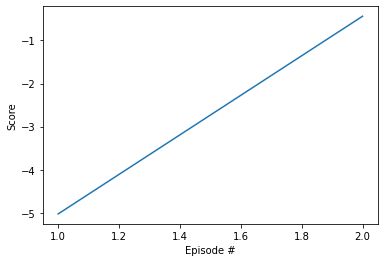

In [ ]:
# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### Animate it with Video

In [ ]:
def show_video(env_name):
    mp4list = glob.glob('video/*.mp4')
    if len(mp4list) > 0:
        mp4 = 'video/{}.mp4'.format(env_name)
        video = io.open(mp4, 'r+b').read()
        encoded = base64.b64encode(video)
        display.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="path:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
    else:
        print("Could not find video")
        
def show_video_of_model(agent, env_name):
    env = gym.make(env_name)
    vid = video_recorder.VideoRecorder(env, path="./{}.mp4".format(env_name))
    agent.load_state_dict(torch.load('checkpoint.pth'))
    state = env.reset()
    done = False
    while not done:
        vid.capture_frame()
        
        action = agent.act(state)
        next_state, reward, done, _ = env.step(action)
        state = next_state
        if done:
            break        
    env.close()

In [ ]:
agent = Agent(env).to(device)
show_video_of_model(agent, 'MountainCarContinuous-v0')

Exception: ignored

In [ ]:
show_video('MountainCarContinuous-v0')

Could not find video


> Note: While I tried to execute the model with VideoRecorder in Linux, it doesn't show correctly. But in windows, it works! Perhaps, It may be bug in VideoRecoder.